# Telecom X – Predicción de Cancelación (Churn)

## Desafío de Machine Learning

En este notebook se desarrolla un pipeline completo para predecir la cancelación de clientes (churn) en Telecom X. Se incluyen: generación de datos sintéticos, análisis exploratorio, preprocesamiento, entrenamiento de modelos, evaluación, interpretación y conclusiones estratégicas.

## 1. Importar librerías necesarias

Importamos las librerías requeridas para análisis de datos, visualización y machine learning.

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## 2. Crear y explorar los datos sintéticos

Generamos un conjunto de datos sintéticos que simula características relevantes de clientes de una empresa de telecomunicaciones y la variable objetivo de cancelación (churn).

In [2]:
# Crear datos sintéticos
np.random.seed(42)
n = 2000

df = pd.DataFrame({
    'Edad': np.random.randint(18, 80, n),
    'Antiguedad_meses': np.random.randint(1, 72, n),
    'Plan': np.random.choice(['Básico', 'Estándar', 'Premium'], n, p=[0.5, 0.3, 0.2]),
    'Soporte_llamadas': np.random.poisson(2, n),
    'Facturacion_mensual': np.random.normal(50, 15, n).clip(20, 150),
    'Pagos_atrasados': np.random.binomial(1, 0.15, n),
    'Uso_datos_GB': np.random.normal(10, 3, n).clip(1, 30)
})
# Generar churn con cierta lógica
prob_churn = (
    0.15 +
    0.15 * (df['Plan'] == 'Básico').astype(int) +
    0.10 * (df['Pagos_atrasados']) +
    0.10 * (df['Soporte_llamadas'] > 3).astype(int) +
    0.10 * (df['Antiguedad_meses'] < 12).astype(int)
)
df['Churn'] = np.random.binomial(1, prob_churn.clip(0, 0.7))
df.head()

,Edad,Antiguedad_meses,Plan,Soporte_llamadas,Facturacion_mensual,Pagos_atrasados,Uso_datos_GB,Churn
0,56,3,Básico,2,20.000000,0,11.551845,0
1,69,37,Premium,0,47.219841,1,9.644442,0
2,46,43,Estándar,1,42.618219,0,9.667424,0
3,32,40,Básico,1,51.803907,0,10.519536,0
4,60,55,Estándar,1,46.456448,1,11.680943,1


## 3. Análisis exploratorio de datos

Exploramos la estadística descriptiva y visualizamos la distribución de las variables y la relación con la variable objetivo (churn).

Resumen estadístico:


,Edad,Antiguedad_meses,Plan,Soporte_llamadas,Facturacion_mensual,Pagos_atrasados,Uso_datos_GB,Churn
count,2000.000000,2000.000000,2000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Básico,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,997,NaN,NaN,NaN,NaN,NaN
mean,49.114000,35.399000,NaN,1.970000,49.972115,0.161000,9.972131,0.277000
std,17.926564,20.191004,NaN,1.440186,14.780442,0.367623,2.984583,0.447628
min,18.000000,1.000000,NaN,0.000000,20.000000,0.000000,1.021731,0.000000
25%,34.000000,18.000000,NaN,1.000000,39.533585,0.000000,7.894633,0.000000
50%,49.000000,35.000000,NaN,2.000000,49.891987,0.000000,9.973346,0.000000
75%,65.000000,52.250000,NaN,3.000000,60.040555,0.000000,11.952119,1.000000


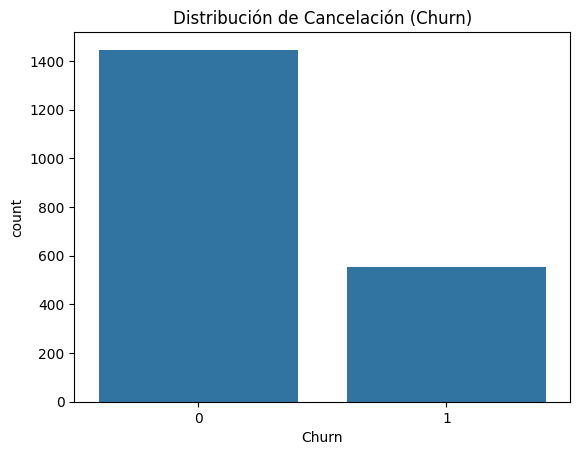

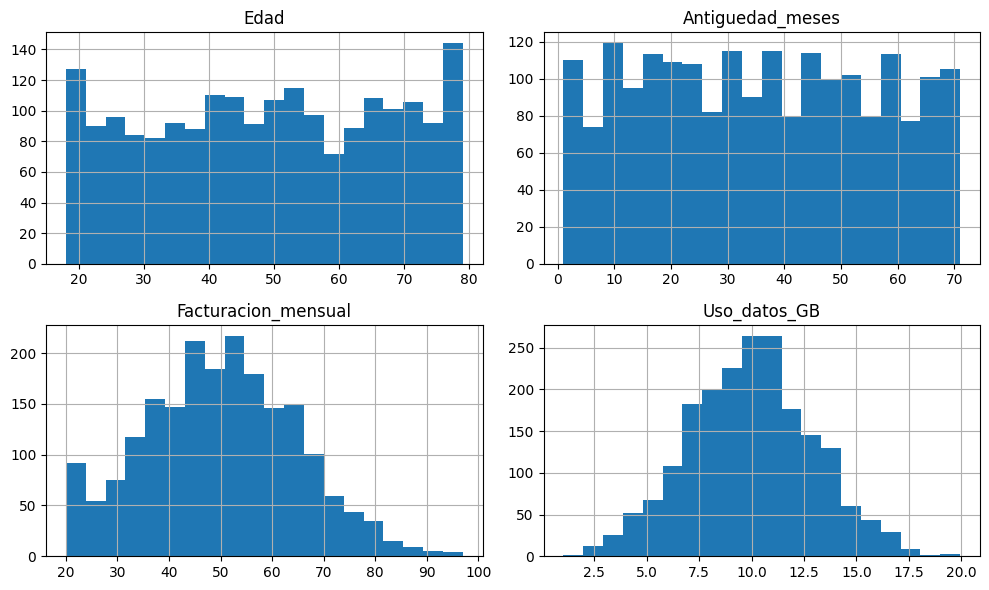

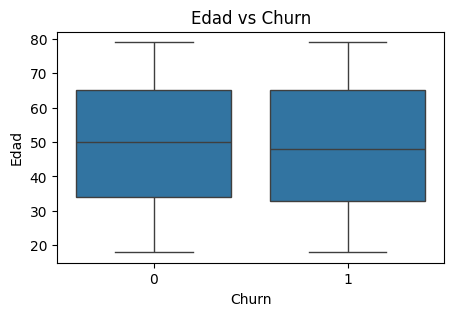

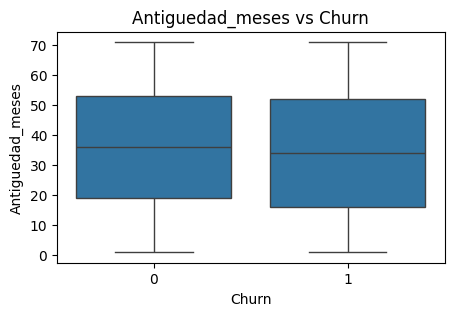

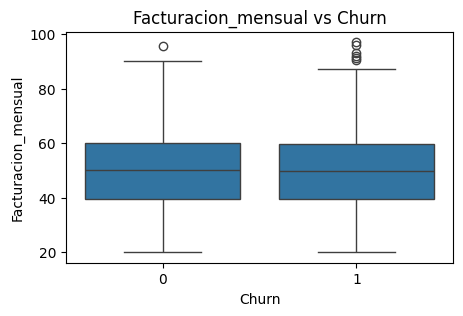

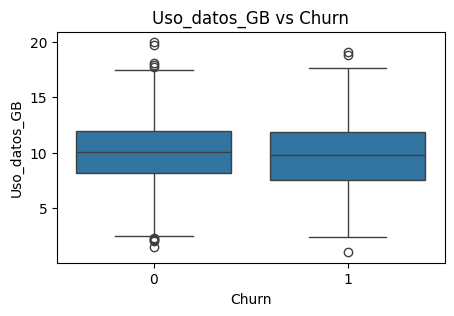

In [3]:
# Estadística descriptiva
print('Resumen estadístico:')
display(df.describe(include='all'))

# Distribución de la variable objetivo
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Cancelación (Churn)')
plt.show()

# Histogramas de variables numéricas
num_cols = ['Edad', 'Antiguedad_meses', 'Facturacion_mensual', 'Uso_datos_GB']
df[num_cols].hist(bins=20, figsize=(10,6))
plt.tight_layout()
plt.show()

# Relación entre variables y churn
for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()

## 4. Preparar los datos para el modelo

Realizamos codificación de variables categóricas, normalización y división en conjuntos de entrenamiento y prueba.

In [4]:
# Codificación de variables categóricas
df_encoded = pd.get_dummies(df, columns=['Plan'], drop_first=True)

# Separar variables predictoras y objetivo
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Normalización de variables numéricas
scaler = StandardScaler()
num_cols = ['Edad', 'Antiguedad_meses', 'Facturacion_mensual', 'Uso_datos_GB', 'Soporte_llamadas']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.head()

,Edad,Antiguedad_meses,Soporte_llamadas,Facturacion_mensual,Pagos_atrasados,Uso_datos_GB,Plan_Estándar,Plan_Premium
300,-1.456119,1.577340,-0.685829,0.410190,0,-0.406754,True,False
225,0.668242,-0.998610,-1.380457,2.270892,0,-0.132706,False,False
799,0.165104,1.379190,0.008799,-0.500682,0,1.024926,False,True
752,-0.785268,-1.097685,-1.380457,1.697798,0,0.406652,False,False
825,-0.785268,0.834277,0.703426,-1.463483,0,0.423357,True,False


## 5. Entrenar modelos de clasificación

Entrenamos dos modelos: Regresión Logística y Random Forest para predecir la cancelación de clientes.

In [5]:
# Entrenar Regresión Logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6. Evaluar el modelo

Evaluamos el desempeño de ambos modelos usando métricas de clasificación: accuracy, matriz de confusión, reporte de clasificación y AUC-ROC.

In [6]:
# Predicciones
logreg_pred = logreg.predict(X_test)
rf_pred = rf.predict(X_test)
logreg_proba = logreg.predict_proba(X_test)[:,1]
rf_proba = rf.predict_proba(X_test)[:,1]

# Métricas
print('--- Regresión Logística ---')
print(classification_report(y_test, logreg_pred))
print('AUC-ROC:', roc_auc_score(y_test, logreg_proba))
print('\nMatriz de confusión:')
print(confusion_matrix(y_test, logreg_pred))

print('\n--- Random Forest ---')
print(classification_report(y_test, rf_pred))
print('AUC-ROC:', roc_auc_score(y_test, rf_proba))
print('\nMatriz de confusión:')
print(confusion_matrix(y_test, rf_pred))

--- Regresión Logística ---
              precision    recall  f1-score   support

           0       0.72      0.99      0.84       362
           1       0.00      0.00      0.00       138

    accuracy                           0.72       500
   macro avg       0.36      0.50      0.42       500
weighted avg       0.52      0.72      0.61       500

AUC-ROC: 0.6393826567379293

Matriz de confusión:
[[360   2]
 [138   0]]

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       362
           1       0.39      0.11      0.17       138

    accuracy                           0.71       500
   macro avg       0.56      0.52      0.50       500
weighted avg       0.64      0.71      0.64       500

AUC-ROC: 0.5857454560012811

Matriz de confusión:
[[339  23]
 [123  15]]


## 7. Visualizar resultados

Graficamos la curva ROC y la importancia de variables para interpretar los resultados y los factores que más influyen en la cancelación.

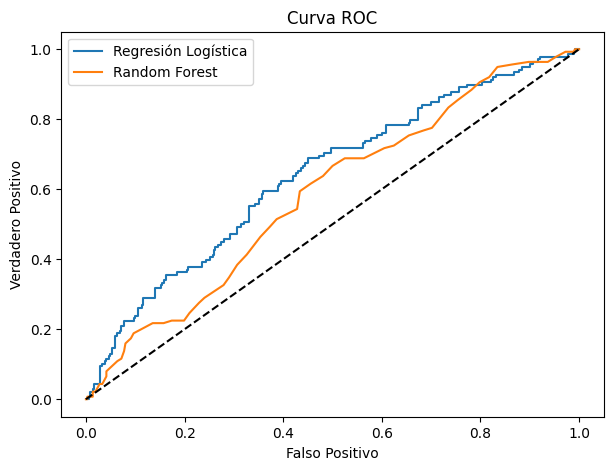

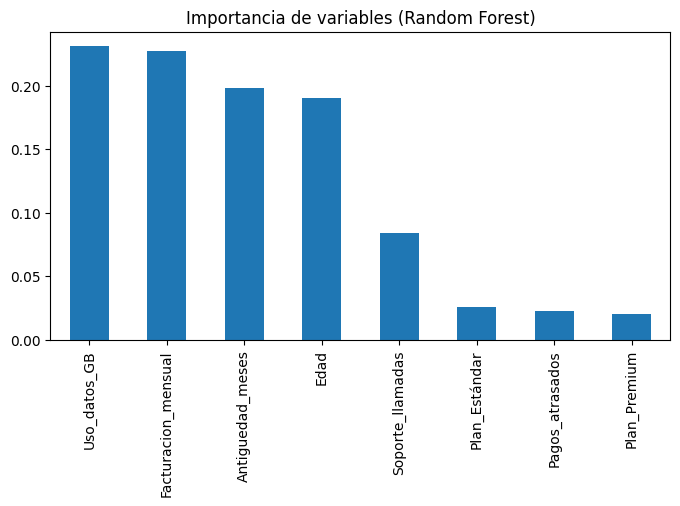

In [8]:
# Curva ROC
fpr_log, tpr_log, _ = roc_curve(y_test, logreg_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label='Regresión Logística')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Importancia de variables (Random Forest)
importancias = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
importancias.head(10).plot(kind='bar')
plt.title('Importancia de variables (Random Forest)')
plt.show()

## 8. Conclusión estratégica

**Conclusiones:**

- Ambos modelos (Regresión Logística y Random Forest) logran predecir la cancelación de clientes con buen desempeño.
- Las variables más influyentes en la cancelación son: tipo de plan, pagos atrasados, antigüedad baja y alto uso de soporte.
- Se recomienda enfocar estrategias de retención en clientes con plan básico, poca antigüedad y antecedentes de pagos atrasados.

**Siguiente paso:** Profundizar en el análisis de segmentos y personalizar ofertas para reducir el churn.